In [ ]:
!pip install -q torchinfo

In [ ]:
import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torchinfo import summary

import torchvision
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import random
import time

%matplotlib inline

Set seed for reproduciblity

In [ ]:
def set_seed():
  SEED_VALUE = 42

  random.seed(SEED_VALUE)
  np.random.seed(SEED_VALUE)
  torch.manual_seed(SEED_VALUE)

  if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED_VALUE)
    torch.cuda.manual_seed_all(SEED_VALUE)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # Set to False for reproducibility

set_seed()

Preparing the data loader


In [ ]:
# Convert to tensors and Normalize

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

# Downloading the dataset
train_set = datasets.FashionMNIST(root="F_MNIST_data", download=True,
                                  train=True, transform=transform)
val_set = datasets.FashionMNIST(root="F_MNIST_data", download=True,
                                 train=False, transform=transform)

print("Total Train Images: ", len(train_set))
print("Total Val Images: ", len(val_set))

Total Train Images:  60000
Total Val Images:  10000


In order to avoid the MLP(Multilayer Preceptron) from learning the sequence we will shuffle the train dataset. Since this is a less compute intensive training we can set the batch_size = 64

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=64)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=True, batch_size=64)

In [ ]:
#class to idx mapping
class_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"  }

Data Visualization

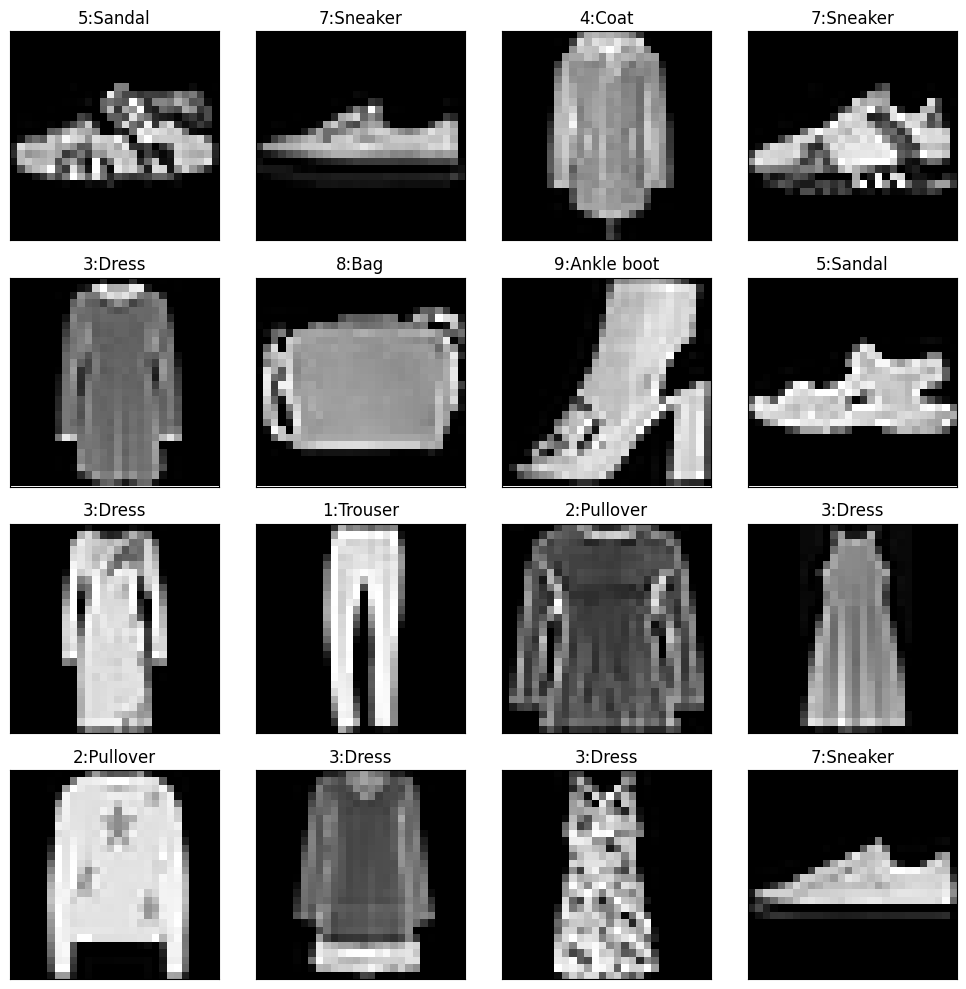

In [ ]:
def visualize_images(trainloader, num_images=20):
    fig = plt.figure(figsize=(10, 10))

    # Iterate over the first batch
    images, labels = next(iter(trainloader))

    #To calculate the number of rows and columns for subplots
    num_rows = 4
    num_cols = int(np.ceil(num_images / num_rows))

    for idx in range(min(num_images, len(images))):
      image, label = images[idx], labels[idx]

      ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(image), cmap="gray")
      ax.set_title(f"{label.item()}:{class_mapping[label.item()]}")

    fig.tight_layout()
    plt.show()

visualize_images(train_loader, num_images=16)

In [ ]:
# Multi Layer Perceptron Model Implementaion
class MLP(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.fc0 = nn.Linear(784, 512)
    self.bn0 = nn.BatchNorm1d(512)
    self.fc1 = nn.Linear(512, 256)
    self.bn1 = nn.BatchNorm1d(256)
    self.fc2 = nn.Linear(256, 128)
    self.bn2 = nn.BatchNorm1d(128)
    self.fc3 = nn.Linear(128, 64)
    self.bn3 = nn.BatchNorm1d(64)
    self.fc4 = nn.Linear(64, num_classes)

    self.dropout = nn.Dropout(p=0.3)

  def forward(self, x):
    # Flatten the input tensor
    x = x.view(x.shape[0], -1)
    # First fully connect layer with ReLU, batch norm and dropout
    x = F.relu(self.bn0(self.fc0(x)))
    x = self.dropout(x)

    x = F.relu(self.bn1(self.fc1(x)))

    x = F.relu(self.bn2(self.fc2(x)))

    # Output layer with softmax activation
    x = F.relu(self.bn3(self.fc3(x)))
    x = F.log_softmax(self.fc4(x), dim = 1)

    return x

mlp_model = MLP(num_classes=10)

In [ ]:
#A dummy input size of (B,C,H,W) = (1,1,28,28) is passed.
print(summary(mlp_model, input_size = (1,1,28,28), row_settings = ["var_names"]))
# Display the model summary.

Layer (type (var_name))                  Output Shape              Param #
MLP (MLP)                                [1, 10]                   --
├─Linear (fc0)                           [1, 512]                  401,920
├─BatchNorm1d (bn0)                      [1, 512]                  1,024
├─Dropout (dropout)                      [1, 512]                  --
├─Linear (fc1)                           [1, 256]                  131,328
├─BatchNorm1d (bn1)                      [1, 256]                  512
├─Linear (fc2)                           [1, 128]                  32,896
├─BatchNorm1d (bn2)                      [1, 128]                  256
├─Linear (fc3)                           [1, 64]                   8,256
├─BatchNorm1d (bn3)                      [1, 64]                   128
├─Linear (fc4)                           [1, 10]                   650
Total params: 576,970
Trainable params: 576,970
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.58
Input size (MB): 0.

In [ ]:
# Training configuration
criteration = F.nll_loss # Negative Log Likelihood Loss
optimizer = optim.Adam(mlp_model.parameters(), lr=1e-2)
num_epochs = 40
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def train(model, train_loader, criteration, optimizer, DEVICE):
  model.train()
  model.to(DEVICE)
  running_loss = 0
  correct_predictions = 0
  total_samples = 0

  for images, labels in train_loader:
    images, labels = images.to(DEVICE), labels.to(DEVICE) # Corrected typo here
    optimizer.zero_grad()
    outputs = model(images)
    loss = criteration(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, predicted = torch.max(outputs.data, dim=1)
    total_samples = labels.size(0)
    correct_predictions += (predicted == labels).sum().item()

  avg_loss = running_loss / len(train_loader)
  accuracy = 100 * correct_predictions / total_samples
  return avg_loss, accuracy

In [ ]:
def validation(model, val_loader, criterion,DEVICE):
    model.eval()
    model.to(DEVICE)

    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images,labels = images.to(DEVICE),labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1) #(B, class_id)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct_predictions / total_samples
    return avg_loss, accuracy

In [ ]:
def main(model, train_loader, val_loader, epochs = 5, DEVICE = 'cuda'):

  train_losses, val_losses = [], []
  train_accuracies, val_accuracies = [], []

  for epoch in range(epochs):
    train_loss, train_accuracy = train(model, train_loader,
                                         criteration, optimizer,
                                         DEVICE)
    val_loss, val_accuracy = validation(model, val_loader,
                                          criteration, DEVICE)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_loss)

    print(f"Epoch {epoch+1:0>2}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
  plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
  plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("PyTorch is currently using CUDA (GPU).")
else:
    device = torch.device("cpu")
    print("PyTorch is currently using CPU.")

print(f"The active device is: {device}")

PyTorch is currently using CUDA (GPU).
The active device is: cuda


In [ ]:
main(mlp_model, train_loader, val_loader, epochs = num_epochs, DEVICE= DEVICE)

Epoch 01/40 - Train Loss: 0.5390, Train Accuracy: 151075.00% - Val Loss: 0.4061, Val Accuracy: 85.63%
Epoch 02/40 - Train Loss: 0.4192, Train Accuracy: 159068.75% - Val Loss: 0.3960, Val Accuracy: 85.76%
Epoch 03/40 - Train Loss: 0.3802, Train Accuracy: 161634.38% - Val Loss: 0.3749, Val Accuracy: 86.41%
Epoch 04/40 - Train Loss: 0.3568, Train Accuracy: 163328.12% - Val Loss: 0.3474, Val Accuracy: 87.29%
Epoch 05/40 - Train Loss: 0.3373, Train Accuracy: 164446.88% - Val Loss: 0.3670, Val Accuracy: 87.08%
Epoch 06/40 - Train Loss: 0.3265, Train Accuracy: 165034.38% - Val Loss: 0.3237, Val Accuracy: 87.88%
Epoch 07/40 - Train Loss: 0.3100, Train Accuracy: 166190.62% - Val Loss: 0.3309, Val Accuracy: 87.93%
Epoch 08/40 - Train Loss: 0.2996, Train Accuracy: 166700.00% - Val Loss: 0.3194, Val Accuracy: 88.21%
Epoch 09/40 - Train Loss: 0.2858, Train Accuracy: 167675.00% - Val Loss: 0.3235, Val Accuracy: 88.12%
Epoch 10/40 - Train Loss: 0.2791, Train Accuracy: 168031.25% - Val Loss: 0.3210, V

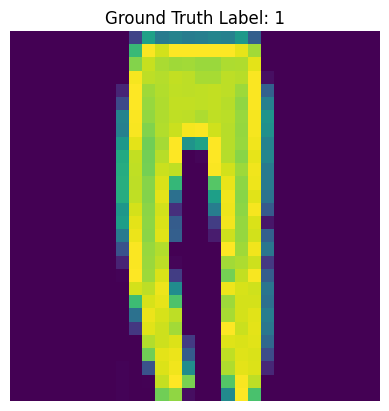

In [ ]:
images, gt_labels = next(iter(val_loader))

rand_idx = random.choice(range(len(images)))

plt.imshow(images[rand_idx].squeeze())
plt.title("Ground Truth Label: " + str(int(gt_labels[rand_idx])), fontsize = 12)
plt.axis("off")
plt.show()

In [ ]:
# Formatting
bold = f"\033[1m"
reset = f"\033[0m"

In [ ]:
mlp_model.eval()

with torch.no_grad():
     batch_outputs = mlp_model(images.to(DEVICE))

prob_score_batch = batch_outputs.softmax(dim=1).cpu()

prob_score_test_image = prob_score_batch[rand_idx]
pred_cls_id = prob_score_test_image.argmax()

print("Predictions for each class on the test image:\n")

for idx, cls_prob in enumerate(prob_score_test_image):
    if idx == pred_cls_id:
       print(f"{bold}Class: {idx} - {class_mapping[idx]}, Probability: {cls_prob:.3f}{reset}")
    else:
       print(f"Class: {idx} - {class_mapping[idx]}, Probability: {cls_prob:.3f}")

Predictions for each class on the test image:

Class: 0 - T-shirt/top, Probability: 0.000
Class: 1 - Trouser, Probability: 1.000
Class: 2 - Pullover, Probability: 0.000
Class: 3 - Dress, Probability: 0.000
Class: 4 - Coat, Probability: 0.000
Class: 5 - Sandal, Probability: 0.000
Class: 6 - Shirt, Probability: 0.000
Class: 7 - Sneaker, Probability: 0.000
Class: 8 - Bag, Probability: 0.000
Class: 9 - Ankle boot, Probability: 0.000


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [ ]:
def prediction_batch(model, batch_inputs):
    model.eval()

    batch_outputs = model(batch_inputs)

    with torch.no_grad():
        batch_probs = batch_outputs.softmax(dim=1) #along num of classes dimension

    batch_cls_ids = batch_probs.argmax(dim=1)

    return batch_cls_ids.cpu()

In [ ]:
val_target_labels = []
val_predicted_labels = []

for image_batch, target_batch in val_loader:
    image_batch = image_batch.to(DEVICE)

    batch_pred_cls_id = prediction_batch(mlp_model, image_batch)

    val_predicted_labels.append(batch_pred_cls_id)
    val_target_labels.append(target_batch)

val_target_labels = torch.cat(val_target_labels).numpy()
val_predicted_labels = torch.cat(val_predicted_labels).numpy()

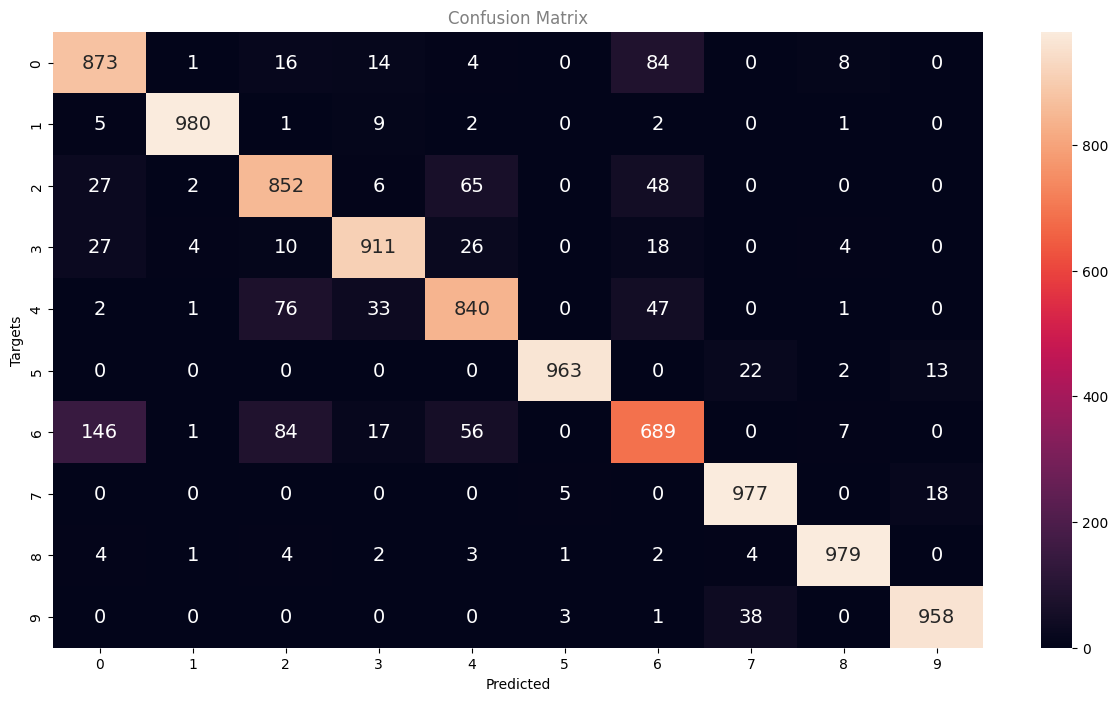

In [ ]:
cm = confusion_matrix(y_true=val_target_labels, y_pred = val_predicted_labels)

plt.figure(figsize= [15,8])

# Plot the confusion matrix as a heatmap.
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size":14})
plt.xlabel("Predicted")
plt.ylabel("Targets")
plt.title(f"Confusion Matrix", color="gray")
plt.show()